In [1]:
### IMPORTS ###
%load_ext autoreload
%autoreload 2
import sys, os
from pathlib import Path
import pandas as pd

# Project-specific imports
sys.path.append(os.path.abspath("../src/utils"))
from visualization import plot_metrics, visualize_slices
from file_io import load_history

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
EXPERIMENT = "exp24_nnunet"
BASE_DIR = Path("../results") / EXPERIMENT
CHECKPOINT_DIR = BASE_DIR / "checkpoints"
MODEL_DIR = BASE_DIR / "models"
LOG_DIR = BASE_DIR / "logs"
PRED_DIR         = BASE_DIR / "predictions"

[fold0] Loading history from ../results/exp24_nnunet/fold0/logs/history_133.json


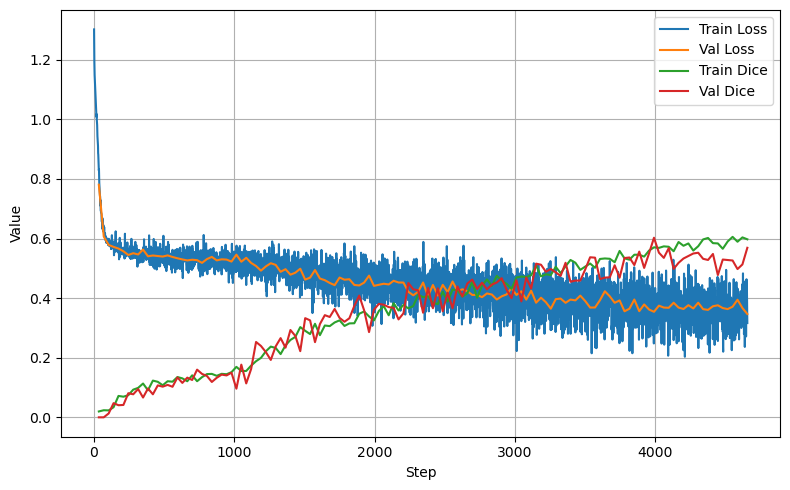


Fold 0 final metrics @ step 4655.0:
  Train Loss = 0.316, Val Loss = 0.347
  Train Dice = 0.597, Val Dice = 0.569
  Train Class1 Dice = 0.535, Val Class1 Dice = 0.513
  Train Class2 Dice = 0.660, Val Class2 Dice = 0.625

Fold 0 best metrics @ step 3990.0:
  Train Loss = 0.398, Val Loss = 0.354
  Train Dice = 0.570, Val Dice = 0.603
  Train Class1 Dice = 0.521, Val Class1 Dice = 0.567
  Train Class2 Dice = 0.620, Val Class2 Dice = 0.638
[fold1] Loading history from ../results/exp24_nnunet/fold1/logs/history_179.json


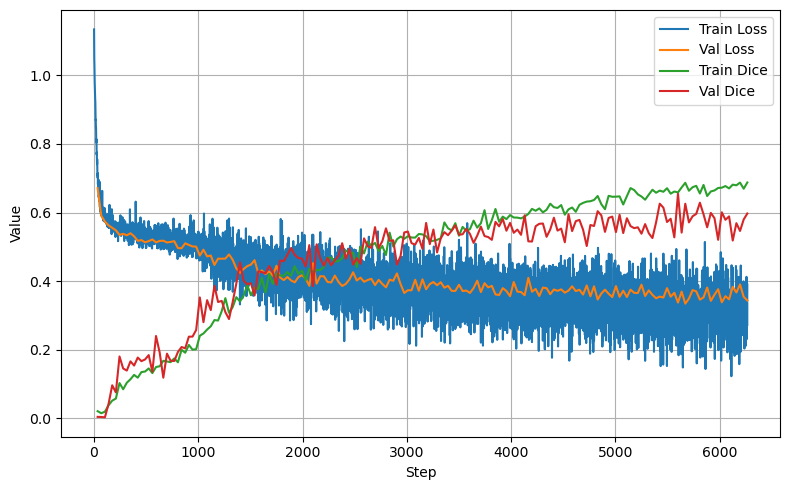


Fold 1 final metrics @ step 6265.0:
  Train Loss = 0.390, Val Loss = 0.343
  Train Dice = 0.688, Val Dice = 0.597
  Train Class1 Dice = 0.633, Val Class1 Dice = 0.581
  Train Class2 Dice = 0.742, Val Class2 Dice = 0.613

Fold 1 best metrics @ step 5600.0:
  Train Loss = 0.305, Val Loss = 0.337
  Train Dice = 0.659, Val Dice = 0.655
  Train Class1 Dice = 0.605, Val Class1 Dice = 0.621
  Train Class2 Dice = 0.712, Val Class2 Dice = 0.689
[fold2] Loading history from ../results/exp24_nnunet/fold2/logs/history_104.json


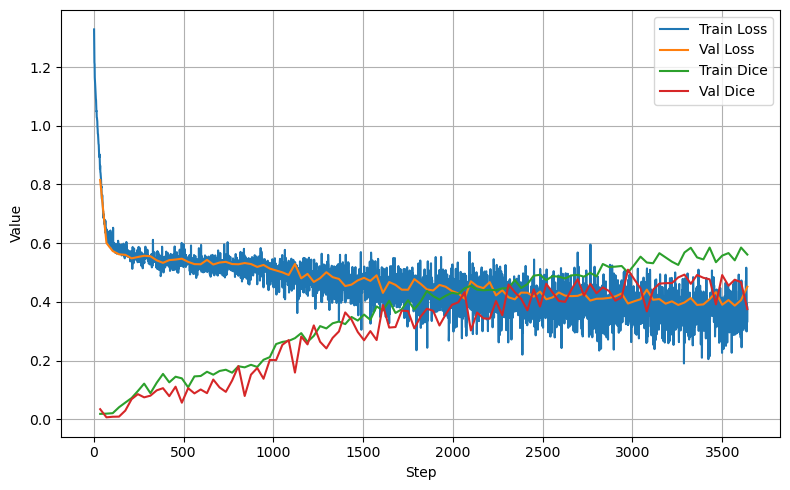


Fold 2 final metrics @ step 3640.0:
  Train Loss = 0.381, Val Loss = 0.452
  Train Dice = 0.561, Val Dice = 0.375
  Train Class1 Dice = 0.513, Val Class1 Dice = 0.241
  Train Class2 Dice = 0.610, Val Class2 Dice = 0.510

Fold 2 best metrics @ step 2975.0:
  Train Loss = 0.321, Val Loss = 0.394
  Train Dice = 0.500, Val Dice = 0.510
  Train Class1 Dice = 0.452, Val Class1 Dice = 0.389
  Train Class2 Dice = 0.548, Val Class2 Dice = 0.630
[fold3] Loading history from ../results/exp24_nnunet/fold3/logs/history_031.json


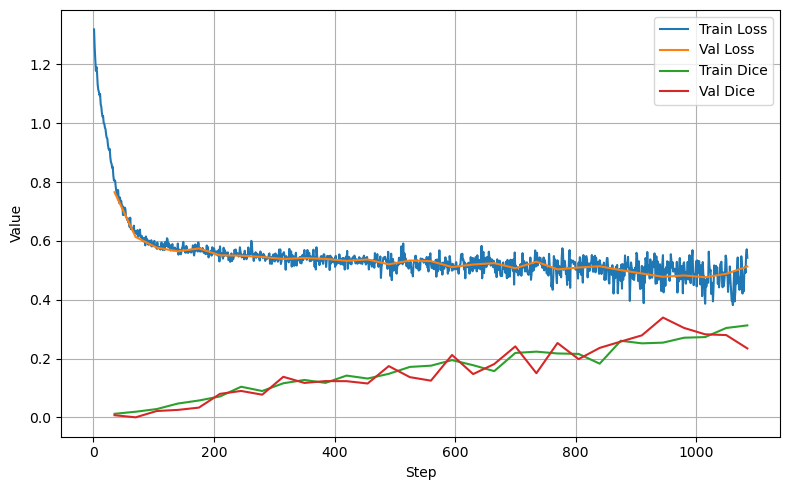


Fold 3 final metrics @ step 1085.0:
  Train Loss = 0.543, Val Loss = 0.513
  Train Dice = 0.313, Val Dice = 0.234
  Train Class1 Dice = 0.319, Val Class1 Dice = 0.255
  Train Class2 Dice = 0.306, Val Class2 Dice = 0.214

Fold 3 best metrics @ step 945.0:
  Train Loss = 0.552, Val Loss = 0.478
  Train Dice = 0.254, Val Dice = 0.339
  Train Class1 Dice = 0.258, Val Class1 Dice = 0.335
  Train Class2 Dice = 0.249, Val Class2 Dice = 0.344

4-fold mean validation Dice: 0.444


In [3]:
# 1) Discover existing fold directories
fold_dirs = sorted(
    [d for d in BASE_DIR.iterdir() if d.is_dir() and d.name.startswith("fold")],
    key=lambda p: int(p.name.replace("fold", ""))
)

all_final_dice = []

for fold_dir in fold_dirs:
    fold_idx = int(fold_dir.name.replace("fold", ""))
    log_dir = fold_dir / "logs"

    if not log_dir.exists():
        print(f"Skipping fold{fold_idx}: no logs directory found.")
        continue

    # 2) Locate and load the latest history JSON
    history_files = sorted(
        log_dir.glob("history_*.json"),
        key=lambda p: int(p.stem.split("_")[-1])
    )
    if not history_files:
        print(f"Skipping fold{fold_idx}: no history_*.json files.")
        continue

    latest_history = history_files[-1]
    print(f"[fold{fold_idx}] Loading history from {latest_history}")
    history = load_history(str(latest_history))

    # 3) Plot training and validation metrics for this fold
    plot_metrics(
        history,
        metrics=[
            ("train",      "loss", "Train Loss",  None),
            ("validation", "loss", "Val Loss",    None),
            ("train",      "dice", "Train Dice",  None),
            ("validation", "dice", "Val Dice",    None),
        ]
    )

    # 4) Extract per-step records into a DataFrame
    records = []
    for step_str in history["validation"]["dice"]:
        records.append({
            "step": int(step_str),
            "train_loss":       history["train"]["loss"].get(step_str),
            "val_loss":         history["validation"]["loss"].get(step_str),
            "train_dice":       history["train"]["dice"].get(step_str),
            "val_dice":         history["validation"]["dice"].get(step_str),
            "train_dice_class1": history["train"].get("dice_class1", {}).get(step_str),
            "val_dice_class1":   history["validation"].get("dice_class1", {}).get(step_str),
            "train_dice_class2": history["train"].get("dice_class2", {}).get(step_str),
            "val_dice_class2":   history["validation"].get("dice_class2", {}).get(step_str),
        })
    df = pd.DataFrame(records).sort_values("step")

    # 5) Print final metrics at last step
    final = df.iloc[-1]
    print(f"\nFold {fold_idx} final metrics @ step {final.step}:")
    print(
        f"  Train Loss = {final.train_loss:.3f}, Val Loss = {final.val_loss:.3f}\n"
        f"  Train Dice = {final.train_dice:.3f}, Val Dice = {final.val_dice:.3f}\n"
        f"  Train Class1 Dice = {final.train_dice_class1:.3f}, Val Class1 Dice = {final.val_dice_class1:.3f}\n"
        f"  Train Class2 Dice = {final.train_dice_class2:.3f}, Val Class2 Dice = {final.val_dice_class2:.3f}"
    )

    # 6) Print metrics at the best validation Dice step
    best_idx = df["val_dice"].idxmax()
    best = df.loc[best_idx]
    print(f"\nFold {fold_idx} best metrics @ step {best.step}:")
    print(
        f"  Train Loss = {best.train_loss:.3f}, Val Loss = {best.val_loss:.3f}\n"
        f"  Train Dice = {best.train_dice:.3f}, Val Dice = {best.val_dice:.3f}\n"
        f"  Train Class1 Dice = {best.train_dice_class1:.3f}, Val Class1 Dice = {best.val_dice_class1:.3f}\n"
        f"  Train Class2 Dice = {best.train_dice_class2:.3f}, Val Class2 Dice = {best.val_dice_class2:.3f}"
    )

    all_final_dice.append(float(final.val_dice))

# 7) Cross-fold summary
if all_final_dice:
    mean_dice = pd.Series(all_final_dice).mean()
    print(f"\n{len(all_final_dice)}-fold mean validation Dice: {mean_dice:.3f}")
else:
    print("No valid folds were processed; no summary to display.")




Label class distribution: (1768545, 0, 927)
Prediction class distribution: (1767851, 308, 1313)


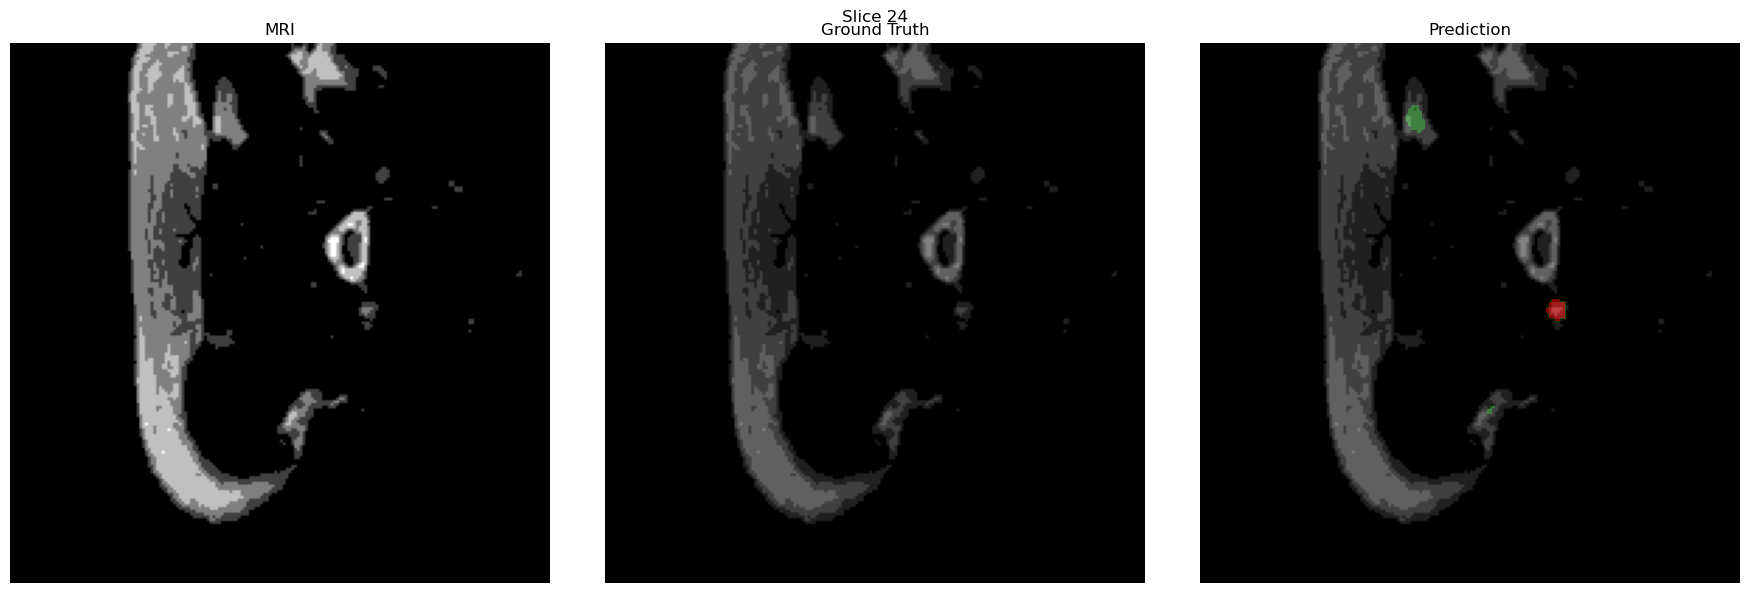

In [17]:
### VISUALIZATION ###
image_path = "../results/exp24_nnunet/fold0/predictions/image_1.nii.gz"
label_path = "../results/exp24_nnunet/fold0/predictions/label_1.nii.gz"
prediction_path = "../results/exp24_nnunet/fold0/predictions/prediction_1.nii.gz"

# Visualize a specific slice (e.g., slice 50)
visualize_slices(image_path, label_path, prediction_path, slice_idx=24)
